# Evolution de l'émission de RX J1713.7-3946

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(347.269, -00.256, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

Emprunt d'une classe implémentée en 0.16

In [3]:
##FoV background estimation
import logging
from gammapy.maps import Map
from gammapy.modeling import Fit, Datasets


class FoVBackgroundMaker:
    """Normalize template background on the whole field-of-view.

    The dataset background model can be simply scaled (method="scale") or fitted (method="fit")
    on the dataset counts.

    The normalization is performed outside the exclusion mask that is passed on init.

    If a SkyModel is set on the input dataset and method is 'fit', its are frozen during
    the fov normalization fit.

    Parameters
    ----------
    method : str in ['fit', 'scale']
        the normalization method to be applied. Default 'scale'.
    exclusion_mask : `~gammapy.maps.WcsNDMap`
        Exclusion mask
    """

    def __init__(self, method="scale", exclusion_mask=None):
        if method in ["fit", "scale"]:
            self.method = method
        else:
            raise ValueError(f"Incorrect method for FoVBackgroundMaker: {method}.")
        self.exclusion_mask = exclusion_mask


    def run(self, dataset):
        """Run FoV background maker.

        Fit the background model norm

        Parameters
        ----------
        dataset : `~gammapy.cube.fit.MapDataset`
            Input map dataset.

        """
        mask_fit = dataset.mask_fit
        dataset.mask_fit = self._reproject_exclusion_mask(dataset)

        if self.method is "fit":
            self._fit_bkg(dataset)
        else:
            self._scale_bkg(dataset)

        dataset.mask_fit = mask_fit
        return dataset


    def _reproject_exclusion_mask(self, dataset):
        """Reproject the exclusion on the dataset geometry"""
        mask_map = Map.from_geom(dataset.counts.geom)
        if self.exclusion_mask is not None:
            coords = dataset.counts.geom.get_coord()
            vals = self.exclusion_mask.get_by_coord(coords)
            mask_map.data += vals

        return mask_map.data.astype("bool")

    def _fit_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""

        # freeze all model components not related to background model
        datasets = Datasets([dataset])

        parameters_frozen = []
        for par in datasets.parameters:
            parameters_frozen.append(par.frozen)
            if par not in dataset.background_model.parameters:
                par.frozen = True

        #!!!AL: relax titlt : BE CARREFULL !!!
        dataset.background_model.tilt.frozen=False
        
        fit = Fit(datasets)
        fit_result = fit.run()
        if fit_result.success is False:
            print("FoVBackgroundMaker failed. No fit convergence")
            

        # Unfreeze parameters
        for i, par in enumerate(datasets.parameters):
            par.frozen = parameters_frozen[i]

    def _scale_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""
        mask = dataset.mask
        count_tot = dataset.counts.data[mask].sum()
        bkg_tot = dataset.background_model.map.data[mask].sum()

        if count_tot <= 0.0:
            print("FoVBackgroundMaker failed. No counts found outside exclusion mask")
        elif bkg_tot <= 0.0:
            print("FoVBackgroundMaker failed. No positive background found outside exclusion mask")
        else:
            scale = count_tot / bkg_tot
            dataset.background_model.norm.value = scale
            #print("bkg scale = ",scale)

## Fabrication des mapdatasets

Define which data to use and print some information

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/samuel/code/gammapy_data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 122853
OBS_ID: 18092 -- 151486
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 20485



In [5]:
from astropy.coordinates import Angle


selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(347.269, 'deg'),
                 lat=Angle(-00.256, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))

obs_table = data_store.obs_table.select_observations(selection)

In [6]:
t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

Sélection par année et tri des observations (on retire celles qui n'ont pas toutes les IRF)

In [7]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    
    for obs in observations_year:
        try:
            obs.aeff
            obs.edisp
            obs.psf
        except:
            ids.remove(obs.obs_id)
            print("Observation retirée : " + str(obs.obs_id))
            
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year

In [30]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=src_pos,
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d= WcsGeom.create(
    skydir=src_pos,
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.1, 200, 20, unit="TeV", name="energy", interp="log"
)

### Création de la géométrie

In [14]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

Fabrication des mapdatasets

In [15]:
%%time

exclusion_region = CircleSkyRegion(src_pos, 1*u.deg)
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

for year in range(2004,2020):
    
    offset_max = 2.0 * u.deg
    maker = MapDatasetMaker()
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)
    maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)
    
    spectrum = PowerLaw2SpectralModel(index=2.3)

    for obs in yearly_obs[year]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)
        
        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)
        
        dataset = maker_bkg.run(dataset)
        
        # The resulting dataset cutout is stacked onto the final one
        mapdataset_dict[year].stack(dataset)

CPU times: user 6min 13s, sys: 1.01 s, total: 6min 14s
Wall time: 6min 16s


Sauvegarde des mapdatasets

In [18]:
from pathlib import Path

#path = Path("$GAMMAPY_DATA/mapdataset_hess/fifth_try")
#path.mkdir(exist_ok=True)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapdatasets_RXJ1713/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year].write(filename, overwrite=True)

# Début de l'analyse (avec mapdatasets déjà écrits)

### Lecture des cartes

In [6]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapdatasets_RXJ1713/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(filename)

### La tête de RX J1713 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fa549cda8d0>)

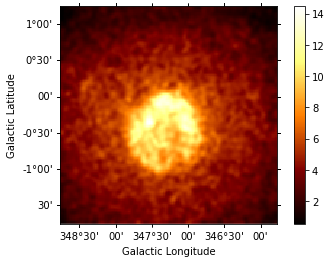

In [7]:
mapdataset_dict[2004].counts.sum_over_axes().cutout(src_pos,3*u.deg).smooth(0.03 * u.deg).plot( add_cbar=True)

In [78]:
for i in range(2004,2020) :
    print(i, mapdataset_dict[i].gti.time_sum.to('h'))
    
goodyears = [2004,2005,2011,2012,2014]

2004 43.7775 h
2005 33.57333333324227 h
2006 0.0 h
2007 0.0 h
2008 0.0 h
2009 0.0 h
2010 0.0 h
2011 38.04638888900479 h
2012 10.739722222205666 h
2013 0.0 h
2014 34.97555555570457 h
2015 0.0 h
2016 0.0 h
2017 0.0 h
2018 0.0 h
2019 0.0 h


In [60]:
dataJ1713 = mapdataset_dict[2004].counts.sum_over_axes().smooth(0.03 * u.deg).data

In [65]:
dataJ1713[ dataJ1713 < 9.5] = 0

In [66]:
J1713map = Map.create(skydir=src_pos,
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",)

In [67]:
J1713map.data = dataJ1713

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fa5480b5ba8>)

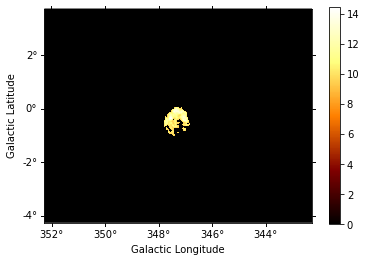

In [68]:
J1713map.plot(add_cbar=True)

In [69]:
mapdataset_dict[2004].counts.sum_over_axes()

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (500, 400)
	ndim  : 2
	unit  : 
	dtype : float32

### Modèle de la source

In [106]:
#J1713map = Map.read(geom, dataJ1713) 


# utile pour retrouver la bonne valeur du flux diffus (intégré sur l'angle solide)
solid_angle_tot = J1713map.geom.solid_angle().sum()

# utile ?
#totalCS = CSmap.quantity*CSmap.geom.solid_angle()
#CSmap.data = CSmap.data/totalCS.value


diffuse_gal = TemplateSpatialModel(J1713map)

#diffuse_gal.parameters["norm"].value = 1.0

powerlaw2 =  PowerLawSpectralModel(
            #emin =0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "2.3e-13 cm-2 s-1 TeV-1")


model_diff = SkyModel(
            spatial_model = diffuse_gal, 
            spectral_model = powerlaw2, 
            name = "DE")

model_diff.parameters["index"].frozen = True
model_diff.parameters["norm"].frozen = True

### Construction du masque

In [121]:
fit_region = CircleSkyRegion(src_pos, 2.5*u.deg)

fit_mask = geom.region_mask([fit_region])

fit_mask = Map.from_geom(geom, data=fit_mask)

# Ajustement du modèle aux cartes

marche du premier coup :)

In [122]:
%%time

for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =   model_diff.copy()
    mapdataset_dict[year].background_model.parameters['norm'].value = 1.0
    #mapdataset_dict[year].background_model.parameters['norm'].frozen = True
    
results_per_year = dict()
results = []


for year in range(2004,2020):
    fit = Fit([mapdataset_dict[year]])
    result = fit.run()
    
    results.append(result)
    results_per_year[year] = result.parameters.to_table()
    

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


CPU times: user 2min 51s, sys: 4.95 s, total: 2min 56s
Wall time: 2min 56s


### Sauvegarde des modèles par année

In [123]:
for year in range(2004,2020):
    mapdataset_dict[year].models.write("../../hess_results/3rd_try_J1713/models/model"+ str(year), overwrite=True)

### Affichage et sauvegarde des résidus

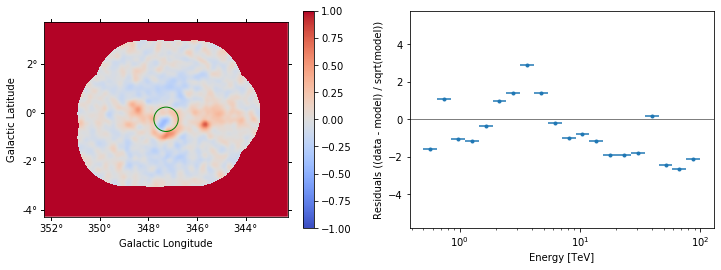

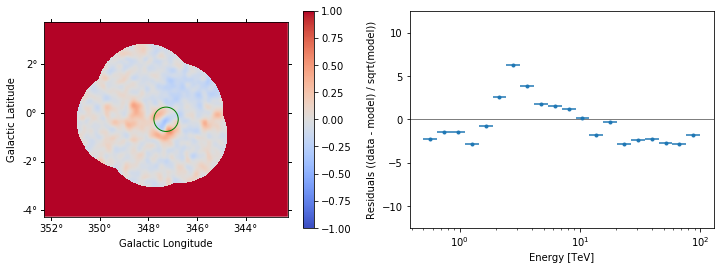

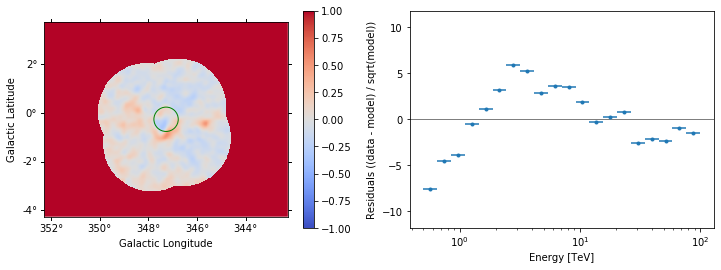

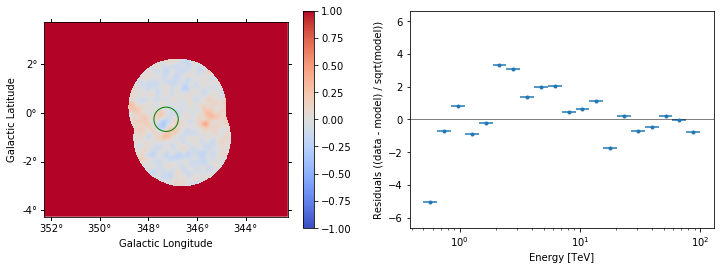

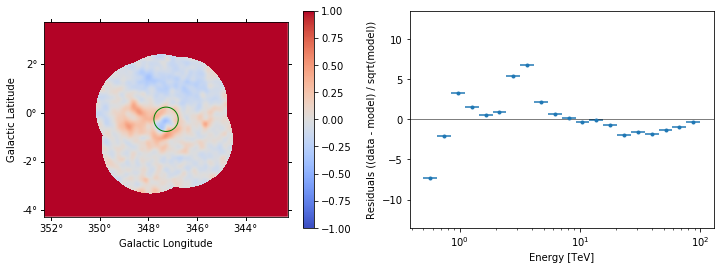

In [124]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in goodyears:
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    plt.savefig("../../hess_results/3rd_try_J1713/residuals/residuals_"+str(year)+".pdf", overwrite=True)


## Etude de l'évolution temporelle de la source/du diffus

In [89]:
def CalculateFluxFromModels(year, emin, emax):
    diffuse_model  = mapdataset_dict[year].models[0]
    
    amplitudediff = results_per_year[year]['value'][2]
    amp_errdiff = results_per_year[year]['error'][2]
    
    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = diffuse_model.spectral_model.integral(emin, emax)*solid_angle_tot  
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = diffuse_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, amplitudediff, amp_errdiff

    #diffuse_index = diffuse_model.spectral_model.index.value
    #diffuse_amp = diffuse_model.spectral_model.amplitude.value
    
    #GC_index = GC_model.spectral_model.index.value
    #GC_amp = GC_model.spectral_model.amplitude.value
     

In [86]:
mapdataset_dict[year].models[0]

SkyModel(spatial_model=<gammapy.modeling.models.spatial.TemplateSpatialModel object at 0x7fa5480780b8>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7fa5480782b0>)

### Tracé de l'évolution

Problèmes actuels :
- l'émission diffuse varie trop (au moins du simple au double)
- l'émission diffuse n'est plus calculabe à partir de 2017
- l'émission diffuse croit "linéairement" en deux temps, pourquoi ?
- le flux de la source évolue clairement avec le flux du diffus, c'est attendu mais cela implique que les valeurs calculées pour le flux de la source sont faussés.
- le fond a une normalisation qui varie trop apparemment

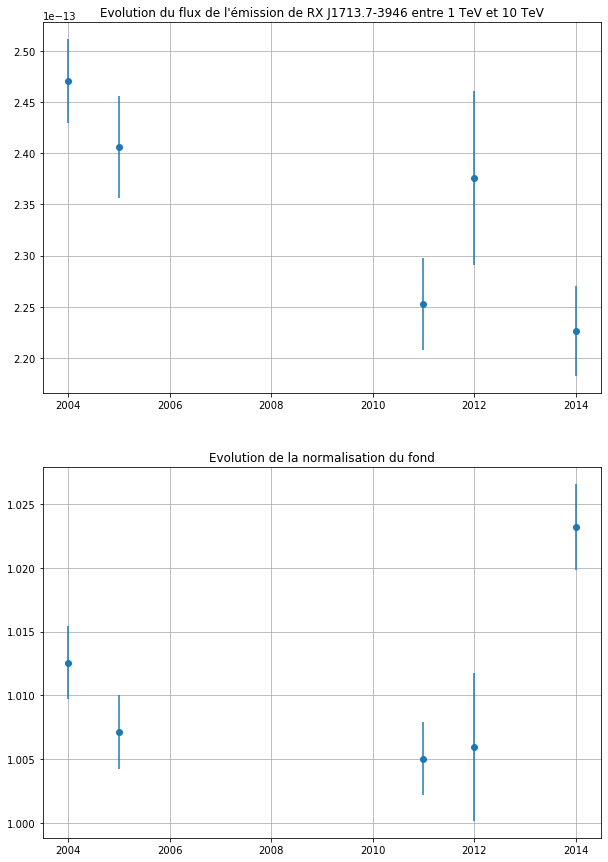

In [125]:
emin = 1.0*u.TeV
emax = 10*u.TeV
resdiff = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in goodyears:
    dif , ampdiff, amp_errdiff = CalculateFluxFromModels(year, emin, emax)
    
    
    resdiff.append(dif.value)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
    
    norms.append(results_per_year[year][4]['value'])
    norms_err.append(results_per_year[year][4]['error'])

plt.figure(figsize=(10,15))


resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)

yerrdiff = (resdiff/ampsdiff)*amp_errsdiff




ax2 = plt.subplot(2,1,1)
plt.errorbar(goodyears , resdiff, yerr=yerrdiff, fmt='o')
plt.title("Evolution du flux de l'émission de RX J1713.7-3946 entre 1 TeV et 10 TeV")
plt.grid()


ax3 = plt.subplot(2,1,2)
plt.errorbar(goodyears , norms, yerr=norms_err, fmt='o')# ax=ax1)
plt.title("Evolution de la normalisation du fond")
plt.grid()

plt.savefig("../../hess_results/3rd_try_J1713/J1713_evolution.pdf")

## Ajustement du modèle d'évolution grâce à astropy

In [119]:
import scipy.stats as stats

from astropy.modeling import models, fitting

def chisq(obs, exp):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(exp**2)
    return chisq


def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr

### Ajustement de l'émission de RX J1713

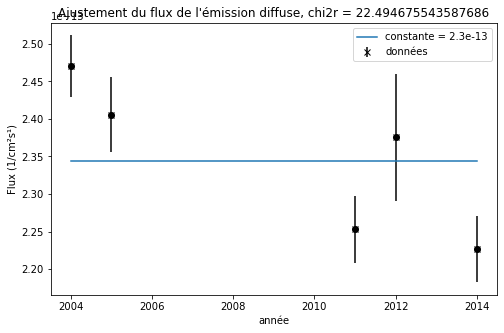

In [126]:
x = goodyears
y = resdiff
y_uncs = yerrdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)

A1 = resdiff
A2 = t(2004)
err_bars = yerrdiff
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de l'émission diffuse, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/3rd_try_J1713/fit_flux_J1713.pdf")